**<center>BỘ GIÁO DỤC VÀ ĐÀO TẠO</center>**
**<center>TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP.HỒ CHÍ MINH</center>**
**<center>KHOA CÔNG NGHỆ THÔNG TIN</center>**
**<center>BÁO CÁO ĐỒ ÁN</center>**
**<center>MÔN HỌC : KHOÁ LUẬN TỐT NGHIỆP</center>**
**<center>TÊN ĐỀ TÀI: DIFFERENTIAL PRIVACY IN DEEP LEARNING</center>**
**<center>GVHD: PGS.TS Hoàng Văn Dũng</center>**
**<center>GVPB: ThS Lê Thị Minh Châu</center>**

**Sinh viên thực hiện**<br>
- Huỳnh Nguyễn Như Nguyên - 20133019<br>
- Lê Minh Trí - 20133100<br>

### Giới thiệu về notebook
Notebook này mô tả về quá trình xây dựng một mô hình mạng CNN giúp phân biệt ảnh mặt thật và giả có áp dụng Differential Privacy.


#### 1. Tải và tiền xử lý dữ liệu

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset,  random_split
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomDataset(Dataset):
    def __init__(self, fake_dir, real_dir, transform=None):
        self.fake_dir = fake_dir
        self.real_dir = real_dir
        self.transform = transform

        self.fake_images = [(os.path.join(fake_dir, img), 1) for img in os.listdir(fake_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.real_images = [(os.path.join(real_dir, img), 0) for img in os.listdir(real_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

        self.all_images = self.fake_images + self.real_images

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path, label = self.all_images[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Đường dẫn tới thư mục chứa ảnh
fake_dir = './data/fake'
real_dir = './data/real'

# Các transform cần thiết cho ảnh
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Tăng cường màu sắc
    transforms.ToTensor(),
])


# Khởi tạo dataset và dataloader
dataset = CustomDataset(fake_dir, real_dir, transform=transform)


#### 2. Chia tập dữ liệu

In [2]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Tạo DataLoader cho từng tập dữ liệu
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 2331
Validation size: 499
Test size: 500


#### 3. Định nghĩa cấu trúc mô hình

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  # Adjust input size to match flattened feature map size
        self.fc2 = nn.Linear(512, 2)  # Adjust output size to 2 for binary classification (fake vs real)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Khởi tạo mô hình
model = CNNModel()

#### 4. Áp dụng Differential Privacy

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!pip install opacus
from opacus.validators import ModuleValidator
import numpy as np
errors = ModuleValidator.validate(model, strict=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 7.9 MB/s eta 0:00:00


In [6]:
import torch.optim as optim
from opacus import PrivacyEngine
privacy_engine = PrivacyEngine(
            accountant="rdp",
            secure_mode=False,
        )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007,weight_decay=1e-5)
from opacus.utils.batch_memory_manager import BatchMemoryManager
model=model.to(device)
model,optimizer,train_loader = privacy_engine.make_private_with_epsilon(
            module=model,
            optimizer=optimizer,
            data_loader=train_loader,
            target_epsilon= 10,
            target_delta=1e-5,
            epochs=100,
            max_grad_norm=1,)

/opt/conda/lib/python3.10/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


#### 5. Huấn luyện mô hình

In [7]:


# Training loop
num_epochs = 100
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'epsilon': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = []
    correct = 0
    total = 0
    with BatchMemoryManager(data_loader=train_loader, max_physical_batch_size=64, optimizer=optimizer) as memory_safe_data_loader:
        for images, labels in memory_safe_data_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss.append( loss.item())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    train_loss = np.mean(running_loss)
    train_acc = 100 * correct / total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    epsilon = privacy_engine.get_epsilon(1e-5)
    history['epsilon'].append(epsilon)
    print(f"---> Privacy budget used: (ε = {epsilon:.2f}, δ = {1e-5}) ")
    model.eval()
    val_loss = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = np.mean(val_loss)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")



/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


---> Privacy budget used: (ε = 1.42, δ = 1e-05) 
Epoch [1/100], Training Loss: 0.6935, Training Acc: 50.26%
Validation Loss: 0.6925, Validation Acc: 51.90%
---> Privacy budget used: (ε = 1.66, δ = 1e-05) 
Epoch [2/100], Training Loss: 0.6937, Training Acc: 48.54%
Validation Loss: 0.6929, Validation Acc: 51.90%
---> Privacy budget used: (ε = 1.88, δ = 1e-05) 
Epoch [3/100], Training Loss: 0.6930, Training Acc: 51.53%
Validation Loss: 0.6926, Validation Acc: 51.90%
---> Privacy budget used: (ε = 2.07, δ = 1e-05) 
Epoch [4/100], Training Loss: 0.6934, Training Acc: 48.24%
Validation Loss: 0.6934, Validation Acc: 48.10%
---> Privacy budget used: (ε = 2.25, δ = 1e-05) 
Epoch [5/100], Training Loss: 0.6930, Training Acc: 51.36%
Validation Loss: 0.6938, Validation Acc: 48.10%
---> Privacy budget used: (ε = 2.42, δ = 1e-05) 
Epoch [6/100], Training Loss: 0.6936, Training Acc: 48.65%
Validation Loss: 0.6928, Validation Acc: 51.90%
---> Privacy budget used: (ε = 2.58, δ = 1e-05) 
Epoch [7/100], 

#### 6. Kiểm tra, đánh giá mô hình

In [8]:
# Testing loop
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")
print(f"Accuracy: {100 * correct / total:.2f}%")

Test Loss: 1.4331
Accuracy: 67.20%


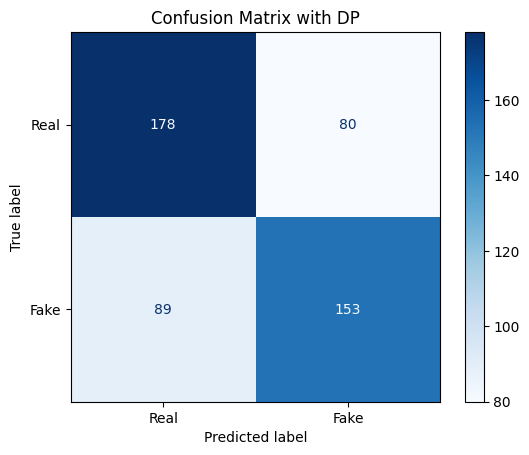

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, test_loader):
    all_labels = []
    all_preds = []

    # Chuyển mô hình sang chế độ đánh giá
    model.eval()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Tính toán ma trận nhầm lẫn
    cm = confusion_matrix(all_labels, all_preds)
    
    # Hiển thị ma trận nhầm lẫn
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix with DP')
    plt.show()

# Gọi hàm để vẽ ma trận nhầm lẫn sau khi đã load mô hình và test_loader
plot_confusion_matrix(model, test_loader)

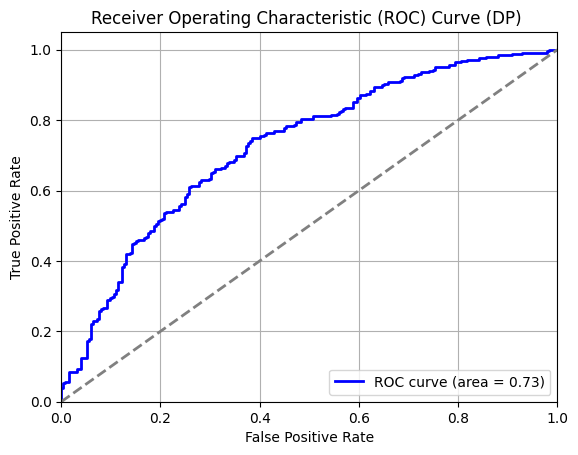

In [10]:
from sklearn.metrics import roc_curve, auc
def plot_roc_auc(model, test_loader):
    all_labels = []
    all_probs = []

    # Chuyển mô hình sang chế độ đánh giá
    model.eval()
    

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            probabilities = F.softmax(outputs, dim=1)[:, 1]
            all_labels.extend(labels.numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Tính toán ROC curve và AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (DP) ')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Gọi hàm để vẽ đường cong ROC và AUC sau khi đã load mô hình và test_loader
plot_roc_auc(model, test_loader)

In [11]:
torch.save(model.state_dict(),'./model/ModelStateDP.pth')
torch.save(model,'./model/ModelDP.pth')

In [12]:
import pickle
history_save_path = './model/history.pkl'
with open(history_save_path, 'wb') as f:
    pickle.dump(history, f)

In [13]:
with open('./model/history.pkl', 'rb') as f:
    history = pickle.load(f)

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Plot for Loss and epsilon
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(history['train_loss'], label='Train Loss', color='tab:blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Epsilon', color='tab:green')  # we already handled the x-label with ax1
    ax2.plot(history['epsilon'], label='epsilon', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Train and Validation Loss and epsilon Over Epochs')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.grid(True)
    plt.show()

    # Plot for Accuracy
    plt.figure(figsize=(6, 5))
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train and Validation Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

<Figure size 1200x500 with 0 Axes>

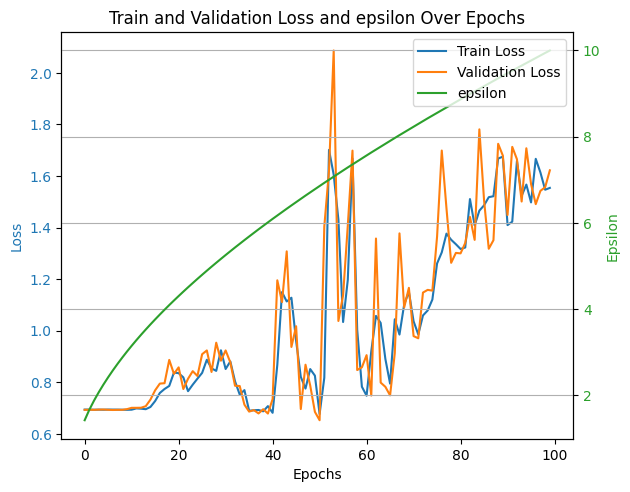

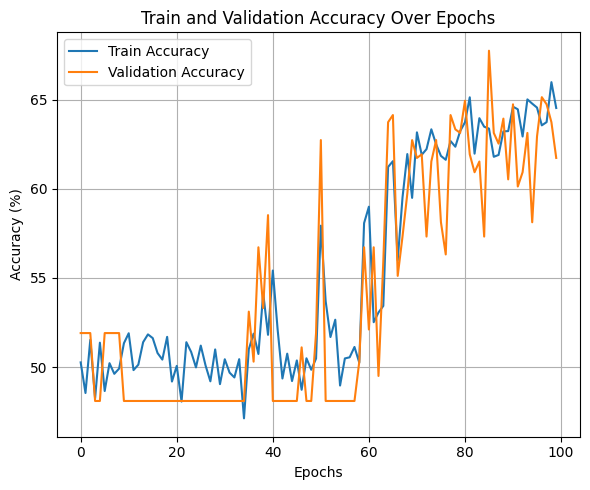

In [15]:
plot_metrics(history)